In [1]:
import os, pickle
from ast import literal_eval
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import logging
from data_creater import *

from scipy.stats import wilcoxon

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization,LSTM

print(tf.keras.__version__)
print(tf.__version__)

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


2.2.4-tf
2.0.0


In [2]:
import warnings
warnings.filterwarnings('ignore')
try:
    import plotly.express as px
except ImportError as e:
    !pip install plotly
    import plotly.express as px

# Introduction

The CDC estimates that as many as 56,000 people die from the flu or flu-like illness each year. Each flu season runs from Octobor to May, and as of mid-March, CDC estimates that between 29,000 and 59,000 have already died due to influenza illnesses this seaon, which has raised concerns.

The goal of our project is to forcast future flu trend. The main data we'll be using is the flu data from September 2010 to July, 2019 across 50 states. We will also incorporate Google Search Data, which contains the Top 25 flu-related queries for each state from Google Analysis using the pytrends API. 

Inspired by https://arxiv.org/abs/1911.02673, we will try different forms of Autoregression and Neural Network models, and compare their results.

# EDA

## Get the data

In [3]:
# flu data
flu_df = pd.read_csv('../data/clean_flu_data.csv')
flu_df.head()

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Nebraska,New Mexico,...,Maine,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,2.199780,2.13191,...,0.357724,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,2.735320,1.96350,...,0.434855,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,3.311030,1.67486,...,0.421743,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,2.057610,2.35498,...,0.338409,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,0.376712,2.37983,...,0.176471,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,0.971705


In addition to the flu activity data, we also downloaded google trends data using the [pytrends](https://pypi.org/project/pytrends/) API.
We selected the search terms based on two parts: 1. Search queries suggested in this [ARGO paper](https://www.pnas.org/content/112/47/14473) that incorporates goole search into flu prediction. 2. Top 25 flu-related google search terms for the corresponding state in the same time period as the flu data.


In [8]:
# Example code for downloaing GT data for Texas
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["flu"]
pytrends.build_payload(kw_list, cat=0, timeframe='2010-01-01 2019-12-31', geo='US-TX') # fetch queries data for 'flu' in Texas
# from 2010-01-01 to 2019-12-31
flu_trend = pytrends.interest_over_time()
flu_trend = flu_trend.reset_index()
flu_trend = pd.DataFrame(flu_trend.iloc[:,:-1])
print(flu_trend)
dict_flu = pytrends.related_queries() # get queries that are related to 'flu' in Texas in the same time period
top_cor = [str(i) for i in dict_flu['flu']['top']['query']]
print('Top 25 queries related to flu: ', top_cor)


          date  flu
0   2010-01-01   12
1   2010-02-01   10
2   2010-03-01    6
3   2010-04-01    4
4   2010-05-01    4
..         ...  ...
115 2019-08-01    6
116 2019-09-01   14
117 2019-10-01   25
118 2019-11-01   26
119 2019-12-01   40

[120 rows x 2 columns]
Top 25 queries related to flu:  ['the flu', 'symptoms', 'flu symptoms', 'flu shot', 'stomach flu', 'symptoms of flu', 'flu vaccine', 'flu shots', 'the flu symptoms', 'texas flu', 'flu virus', 'flu contagious', 'flu 2018', 'flu medicine', 'flu season', 'how long does flu last', 'symptoms of the flu', 'what is the flu', 'flu a symptoms', 'swine flu', 'flu test', 'flu type a', 'tamiflu', 'stomach flu symptoms', 'cold symptoms']


## Data Cleaning

We discovered a mismatch between Google Trends data's dates, which is in the format of `YYYY-mm-dd`, and the date format of the flu data, which is in a format of `YYYY-week_number`. Therefore, we convert the two date columns into the same format.

In [6]:
def col_to_weeknum(df):
    df['date'] = pd.to_datetime(df['date'])
    week_num = df['date'].apply(lambda x: datetime.date(x.year, x.month, x.day).isocalendar()[1])
    df['date'] = [str(d.year) +'-'+ str(wn) for d,wn in zip(df['date'], week_num)]
    return df

def clean_google_df(state, to_return = False, save = False):
    df_google = pd.read_csv('../data/google/' + state + '.csv')
    print(df_google.shape)
    # Clean the date column if in wrong format
    if len(df_google.loc[0, 'date']) > 7:
        df_google = col_to_weeknum(df_google)
    
    all_dates = flu_df[['date']]
    clean_data = pd.merge(all_dates, df_google, how = 'left', on = 'date').fillna(method='backfill').fillna(method='ffill')
    assert clean_data.isna().sum().sum() == 0
    if save:
        clean_data.to_csv('../data/google_clean/'+state+'.csv', index = None)
    if to_return:
        return clean_data

ny_google = clean_google_df('New York', True)
ny_google.head()

(120, 97)


,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,cold vs. flu,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,35.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0
1,2010-41,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,35.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0
2,2010-42,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,35.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0
3,2010-43,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,35.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0
4,2010-44,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,35.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0


In addition, to make model evaluation easier, we also splitted the flu data for each state into training and testing periods, where the training size is 80% of the entire time period we have. Besides, we have also created columns named `target_1`, `target_2`, `target_4`, and `target_8` to indicate the 1, 2, 4, and 8 weeks ahead flu index. These columns serve as the prediction target for our models described below. 

Below is the code we used to clean datasets for all of the states.

In [9]:
def get_clean_data_for_state(state, if_return = False, save = False):
    df_flu = flu_df[['date', state]].copy()
    state_name = state.lower().replace(" ","_")
    df_flu.columns = ['date', state_name+'_flu']
    google_data = pd.read_csv('../data/google_clean/'+state+'.csv')
    df = pd.merge(df_flu, google_data, on = 'date', how = 'inner')
    df['target_1'] = df[state_name+'_flu'].shift(-1)
    df['target_2'] = df[state_name+'_flu'].shift(-2)
    df['target_4'] = df[state_name+'_flu'].shift(-4)
    df['target_8'] = df[state_name+'_flu'].shift(-8)
    df = df.dropna()
    assert df.shape[0] == df_flu.shape[0]-8
    
    train_size = int(df_flu.shape[0] * 0.8)
    df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]
    save_base = '../data/state_flu_google/'
    train_base = save_base + 'train/'
    test_base = save_base + 'test/'
    
    if save:
        df_train.to_csv(train_base + state + '.csv', index = None)
        df_test.to_csv(test_base + state + '.csv', index = None)
    assert len(df_train) + len(df_test) == len(df)
    print(df.shape)
    if if_return:
        return df_train, df_test
    

df_train, df_test = get_clean_data_for_state('New York', True)
print(f"Training period range is:", min(df_train.date), max(df_train.date))
print(f"Testing period range is:", min(df_test.date), max(df_test.date))
df_train.head()

(453, 102)
Training period range is: 2010-40 2017-42
Testing period range is: 2017-43 2019-23


,date,new_york_flu,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,...,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu,target_1,target_2,target_4,target_8
0,2010-40,0.262990,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,8.0,11.0,9.0,26.0,0.0,0.369729,0.362121,0.527357,1.62591
1,2010-41,0.369729,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,8.0,11.0,9.0,26.0,0.0,0.362121,0.358981,0.504756,2.16290
2,2010-42,0.362121,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,8.0,11.0,9.0,26.0,0.0,0.358981,0.527357,0.503441,2.68099
3,2010-43,0.358981,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,8.0,11.0,9.0,26.0,0.0,0.527357,0.504756,0.549190,3.84844
4,2010-44,0.527357,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,8.0,11.0,9.0,26.0,0.0,0.504756,0.503441,1.625910,4.19925


## Visualization

### Flu data

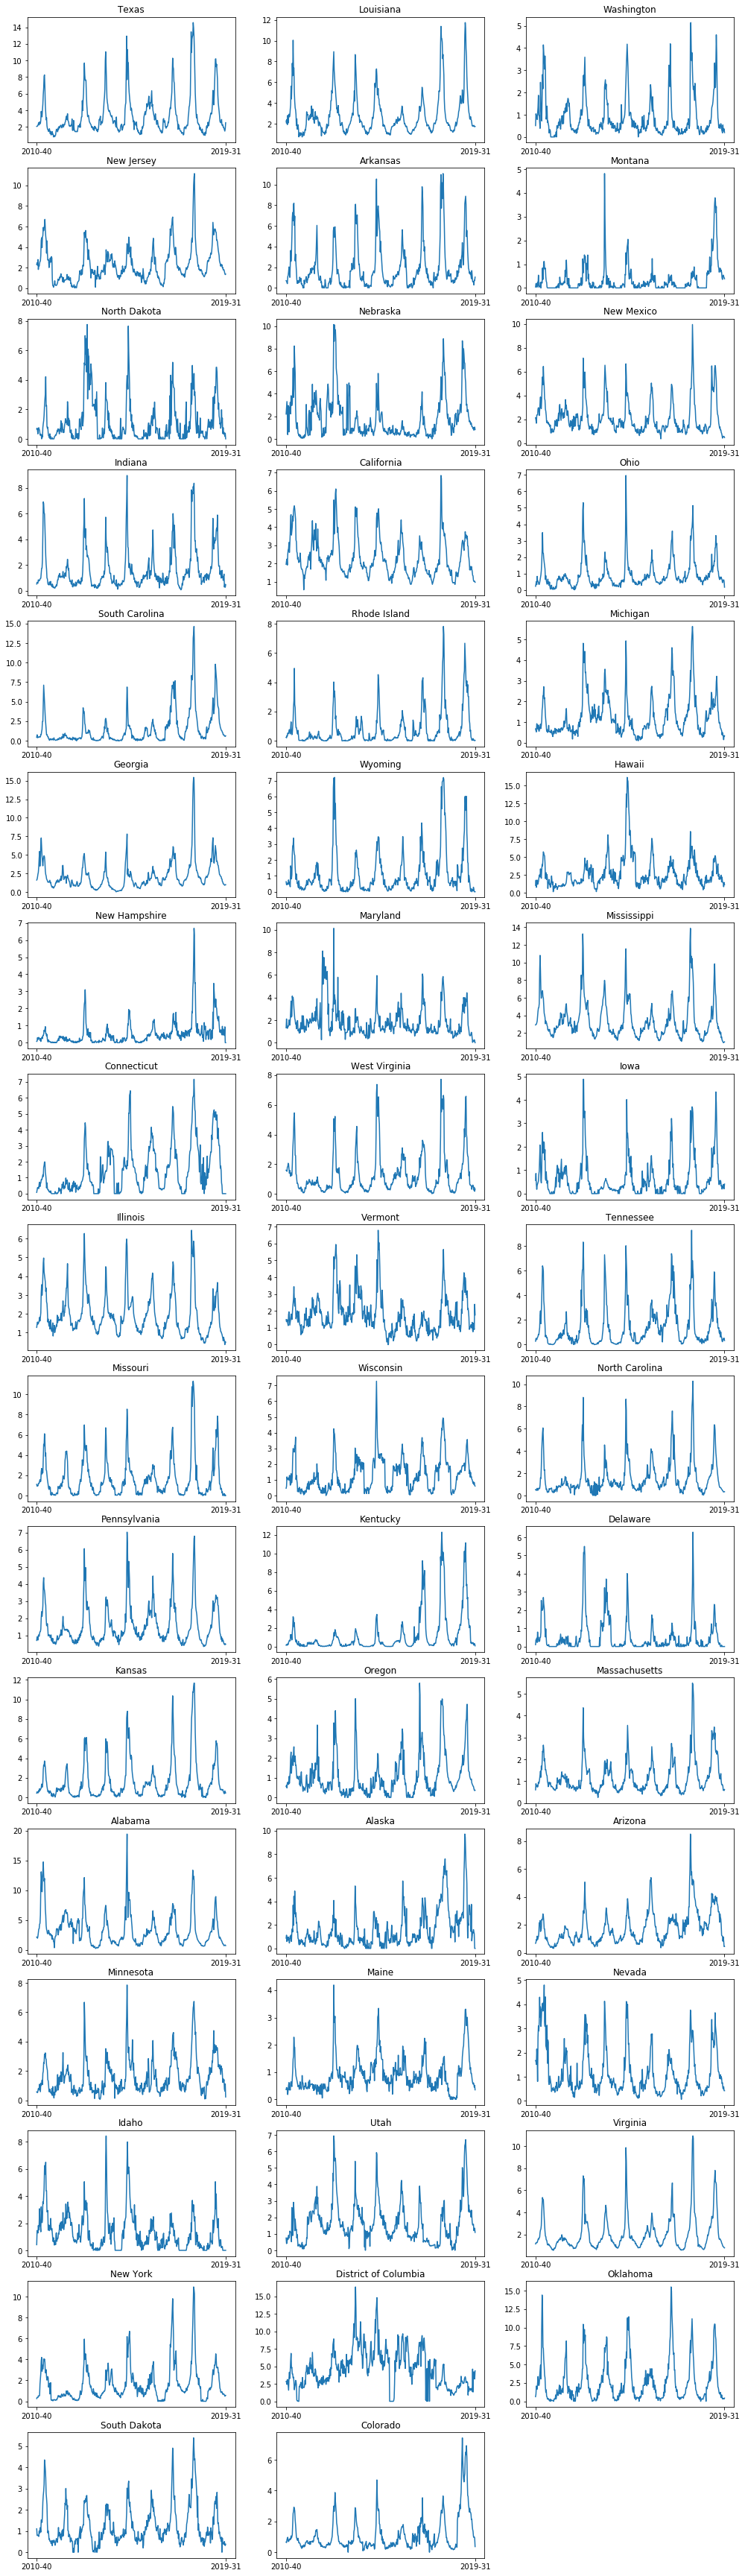

In [4]:
cols = flu_df.columns[1:]

plt.figure(figsize = (17, 100))
for i in np.arange(0, len(cols), 3):
    plt.subplot(27, 3, i+1)
    plt.plot(flu_df[cols[i]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i])
    
    plt.subplot(27, 3, i+2)
    plt.plot(flu_df[cols[i+1]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i+1])
    
    if i == 48:
        break

    plt.subplot(27, 3, i+3)
    plt.plot(flu_df[cols[i+2]])
    plt.xticks([0,len(flu_df.date)-1], labels = [flu_df.date.iloc[0], flu_df.date.iloc[-1]])
    plt.title(cols[i+2])    

In [10]:
# Plot the flu data for all states on the last time-stamp: 2019-31
final_state = flu_df.drop(columns = 'date').loc[460,:]
final_state = pd.DataFrame(final_state)
final_state = final_state.reset_index()
final_state = final_state.rename(columns={'index': 'states',460: 'wili'})
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR',
    'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE',
    'District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID',
    'Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY',
    'Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH',
    'Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'
}
final_state['states'] = final_state['states'].map(us_state_abbrev)


fig = px.choropleth(final_state, locations="states",
                    color="wili", 
                    hover_name="states",
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode = 'USA-states')

fig.update_layout(
    title_text = 'Flu data for all states, 2019 - 31', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()

In case the above interactive plot does not work on github, we include the same picture here as well.

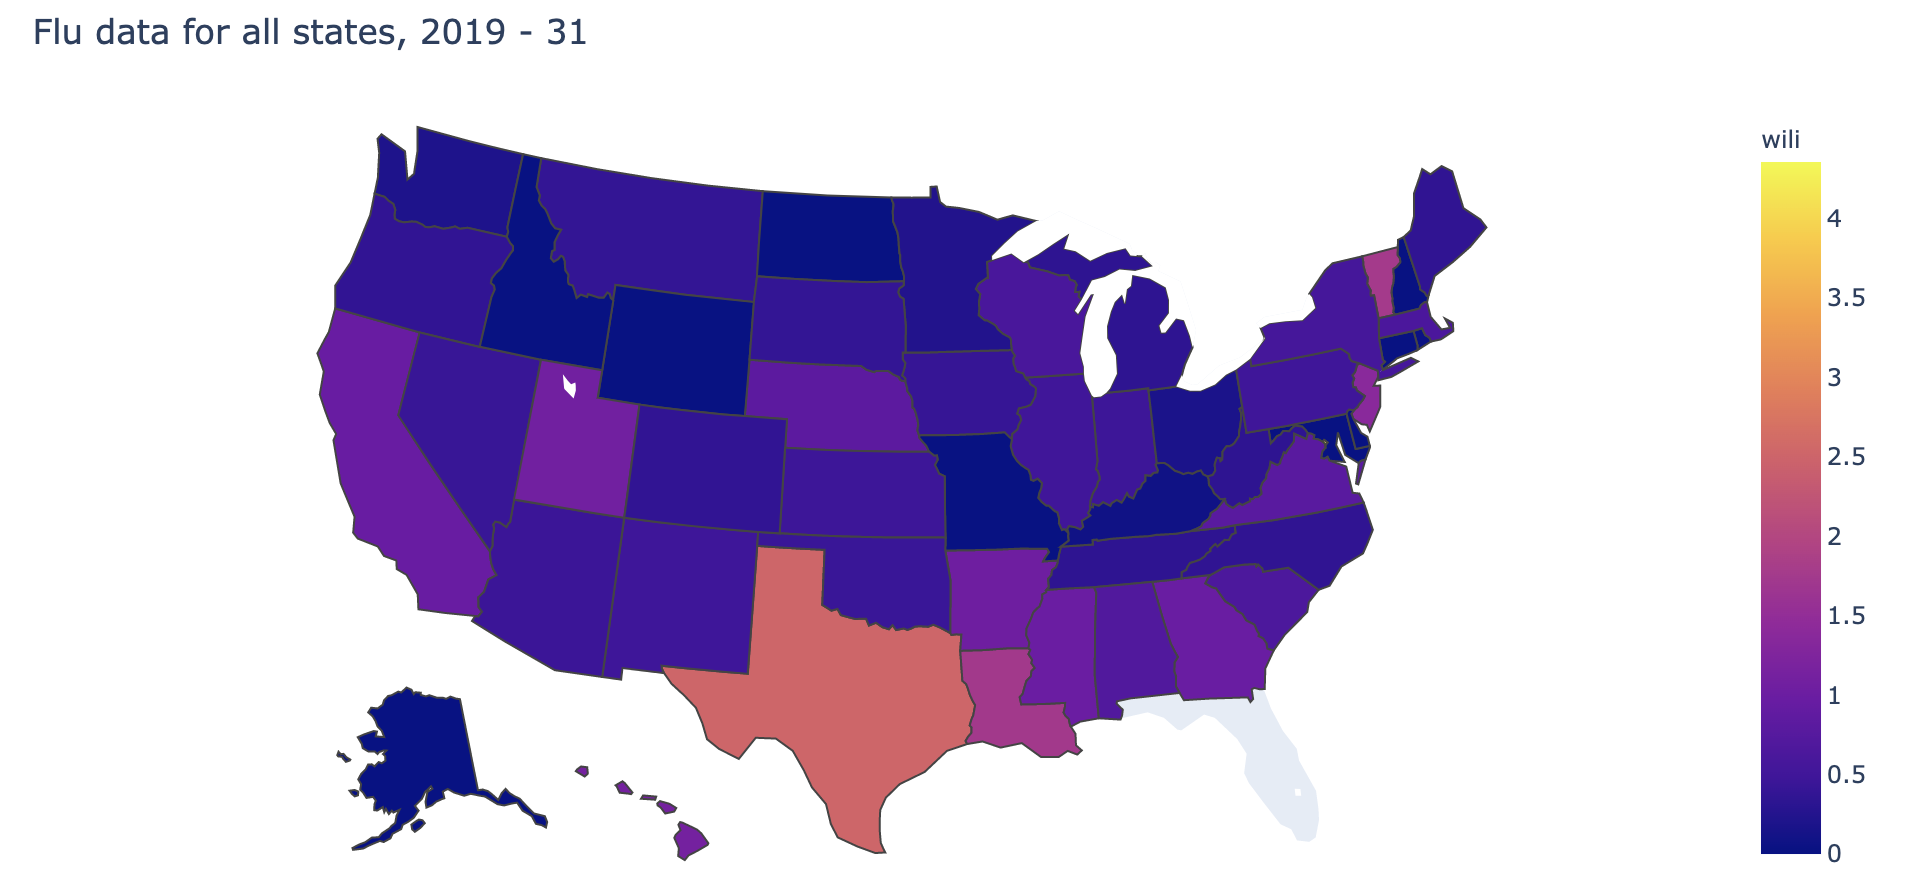

In [1]:
from IPython.display import Image
Image(filename='../data/flu_map.png')

# Model

## Perpare the Data

In [3]:
# Load in dfs for all states
all_states = [] # List of all the states
train_dfs, test_dfs = {}, {}
train_path = '../data/state_flu_google/train/'
test_path = '../data/state_flu_google/test/'

for root,dirs,files in os.walk(train_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            all_states.append(state)
            train_dfs[state] = pd.read_csv(train_path + file)

for root,dirs,files in os.walk(test_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            test_dfs[state] = pd.read_csv(test_path + file)

In [4]:
# helper function to normalize the data
def minmax_transform(X_train, X_test):
    """ Uses MinMaxScaler to scale X_train and X_test
        to 0 and 1, scaled using X_train
    """
    scalar = MinMaxScaler().fit(X_train)
    X_test = scalar.transform(X_test)
    X_train = scalar.transform(X_train)
    return X_train, X_test
# helper function to reverse normalization
def inverse_transform_preds(y_train, y_pred):
    """ Uses MinMaxScaler to scale y_pred to the 
        original range as y_train
    """
    scalar = MinMaxScaler().fit(y_train)
    transformed_preds = scalar.inverse_transform(y_pred)
    return transformed_preds

In [5]:
# helper function to get predictors
def get_X(option, state, predictor_state_list):
    """ Get data according to option
    """ 
    assert option in ['TS', 'GT', 'other_states'] or option.startswith('lag_')

    # Get dfs
    df_train, df_test = train_dfs[state], test_dfs[state]

    # Modify flu_df
    flu_df_train = pd.merge(flu_df.drop(state,1), df_train[['date']], on = 'date', how = 'right')
    flu_df_test = pd.merge(flu_df.drop(state,1), df_test[['date']], on = 'date', how = 'right')
    flu_df_train = flu_df_train.drop('date', 1)
    flu_df_test = flu_df_test.drop('date', 1)

    # Drop all target columns and date column
    target_cols = [c for c in df_train.columns if c.startswith('target')]
    drop_cols = target_cols + ['date']
    df_train = df_train.drop(drop_cols,1)
    df_test = df_test.drop(drop_cols,1)

    # Flu for the current state
    flu_colname = state.lower().replace(" ","_")+"_flu"

    if option == 'TS':
        X_train_ts = df_train[[flu_colname]]
        X_test_ts = df_test[[flu_colname]]
        X_train_ts, X_test_ts = minmax_transform(X_train_ts, X_test_ts)
        X_all_ts = np.concatenate((X_train_ts, X_test_ts))
        return X_train_ts, X_test_ts, X_all_ts
    if option == 'GT':
        gt_columns = list(df_train.columns.difference([flu_colname]))
        X_train_gt = df_train[gt_columns]
        X_test_gt = df_test[gt_columns]
        X_train_gt, X_test_gt = minmax_transform(X_train_gt, X_test_gt)
        X_all_gt = np.vstack((X_train_gt, X_test_gt))
        return X_train_gt, X_test_gt, X_all_gt
    if option == 'other_states':
        # Default predictor_state_list to be all states other than input state
        if predictor_state_list == None:
            predictor_state_list = flu_df_train.columns
        X_train_states = flu_df_train[predictor_state_list]
        X_test_states = flu_df_test[predictor_state_list]
        X_train_states, X_test_states = minmax_transform(X_train_states, X_test_states)
        X_all_state = np.vstack((X_train_states, X_test_states))
        return X_train_states, X_test_states, X_all_state
    if option.startswith('lag_'):
        n_lag = int(option[4:])
        X_train_ts = df_train[[flu_colname]].shift(n_lag).fillna(method='bfill')
        X_test_ts = df_test[[flu_colname]].shift(n_lag).fillna(method='bfill')
        X_train_ts, X_test_ts = minmax_transform(X_train_ts, X_test_ts)
        X_all_ts = np.concatenate((X_train_ts, X_test_ts))
        assert np.isnan(X_all_ts.flatten()).sum() == 0
        return X_train_ts, X_test_ts, X_all_ts

In [6]:
# helper function to get response
def get_y(state, target_lag):
    """Get the target with the desired target_lag
    """
    assert target_lag in [1,2,4,8]
    # Flu for the current state
    df_train, df_test = train_dfs[state], test_dfs[state]
    target_train = df_train[[f'target_{target_lag}']].values
    target_test = df_test[[f'target_{target_lag}']].values
    target_all = np.concatenate((target_train, target_test))
    return target_train, target_test, target_all

In [7]:
# get train & test data
def get_data(  state,
               option_list = ['TS'],
               target_lag = 1,
               predictor_state_list = None
               ):
    """ Create desired dataset according to option_list for state
        Inputs:
            state: state name 
            option_list: one of ['TS', 'GT', 'other_states'], corresponding to
                time series, google trends, other states flu data
            target_lag: target lag, one of 1,2,4,8
            predictor_state_list: list of other states to consider
    """
    # Get the appropriate df_train and df_test given state
    df_train = train_dfs[state]
    df_test = test_dfs[state]

    # Get all data according to option_list
    X_train, X_test, X_all = get_X(option_list[0], state, predictor_state_list)

    for option in option_list[1:]:
        X_train_t, X_test_t, X_all_t = get_X(option, state, predictor_state_list)
        X_train = np.hstack((X_train,X_train_t))
        X_test = np.hstack((X_test,X_test_t))
        X_all = np.hstack((X_all,X_all_t))

    # Get the target
    y_train, y_test, y_all = get_y(state, target_lag)

    # Return X, y
    return X_train, X_test, X_all, y_train, y_test, y_all

In [8]:
# helper function to plot predictions
def plot_predictions(y_train, y_test, model_name, y_pred, model_name_gt = None, y_pred_gt = None):
    title = f"{model_name} Performance"
    print(f'Test RMSE for {model_name}: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    y_train = y_train[-100:]
    train_len = len(y_train)
    test_len = len(y_test)
    
    plt.figure(figsize=(20,8))
    plt.plot(range(train_len), y_train, label = 'y_train')
    plt.plot(range(train_len, train_len + test_len), y_test, c='g', label = 'y_test')
    plt.plot(range(train_len, train_len + test_len), y_pred, c='orange', ls='--', label = 'y_pred')
    if y_pred_gt is not None:
        print(f'Test RMSE for {model_name_gt}: ', np.sqrt(mean_squared_error(y_test, y_pred_gt)))
        plt.plot(range(train_len, train_len + test_len), y_pred_gt, c='red', ls='--', label = 'y_pred gt')
        title = f"{model_name} & {model_name_gt} Performance"
    plt.legend()
    plt.title(title)

## Persistence

We use the Persistence model as the baseline model. The model uses the data from date t-1 to predict date t.
$$\hat{x}_{t+1} = x_{t}$$

In [9]:
def persistence(target_state, target_lag, if_plot=True, verbose=1):
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS'], target_lag, None)
    
    # model and predict
    y_pred = inverse_transform_preds(y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the persistence model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

<Figure size 576x432 with 0 Axes>

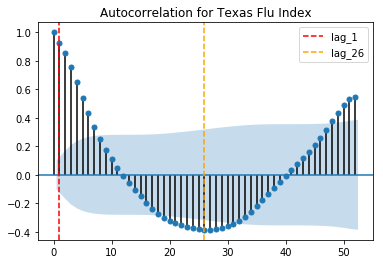

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(8,6))
plot_acf(train_dfs['Texas']['target_1'].values, lags=52)
plt.axvline(1, ls = '--', c = 'red', label = 'lag_1')
plt.axvline(26, ls = '--', c = 'orange', label = 'lag_26')
plt.legend()
plt.title("Autocorrelation for Texas Flu Index")
plt.show()

RMSE for the persistence model of Texas is 1.023945


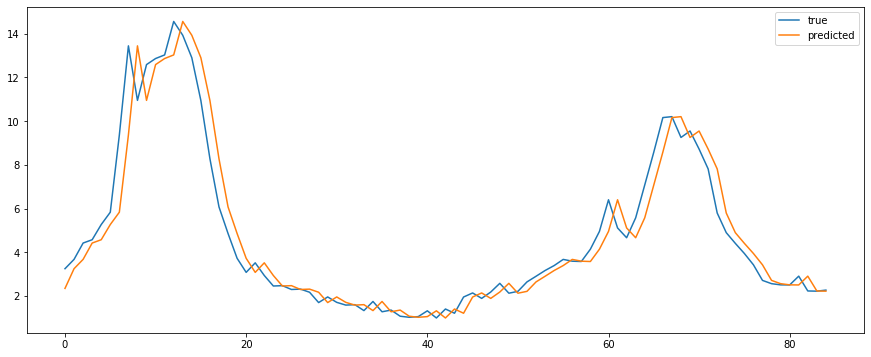

RMSE for the persistence model of New York is 0.678804


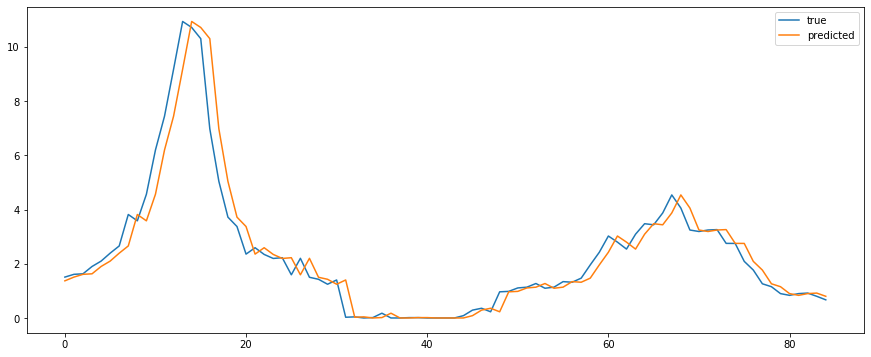

0.6788041820756451

In [13]:
persistence('Texas', 1, True)
persistence('New York', 1, True)

## Autoregression(AR)

The basic Linear Autoregression model uses the linear combination of autoregressive flu observations to forcast future flu trend (1-week, 2-week, 4-week, 8-week), 26 autoregressive terms were used to cover 6 months(26 weeks). Each model is retrained on a pre-defined time period with all data available.

$$\hat{x}_{t+1} = \phi_0 + \phi_1x_t + \phi_2x_{t-1}+\phi_px_{t+1-p} + \epsilon_{t+1},~~\epsilon_{t+1}\sim N(0,1)$$

In [14]:
def AutoReg_Walk_Forward(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            # If retrain, retrain at every refit_period steps
            if t % refit_period == 0: 
                AR = LinearRegression().fit(X_train_temp, y_train_temp)
        else:
            # If not retrain, only train at the first period
            if t == 0: 
                AR = LinearRegression().fit(X_train_temp, y_train_temp)
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the AutoReg Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

RMSE for the AutoReg Model of Texas is 0.979252


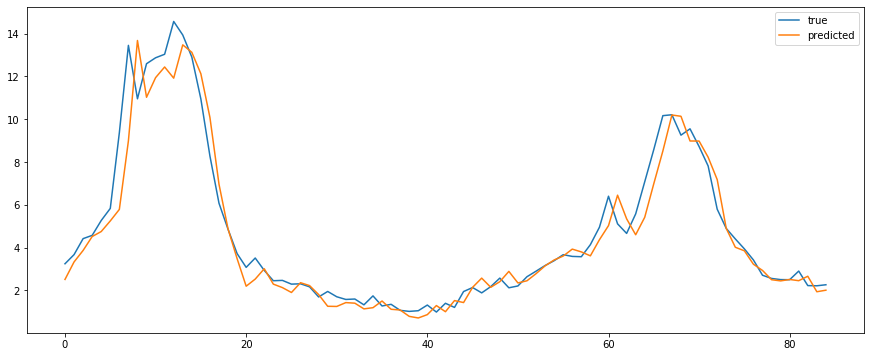

RMSE for the AutoReg Model of New York is 0.636332


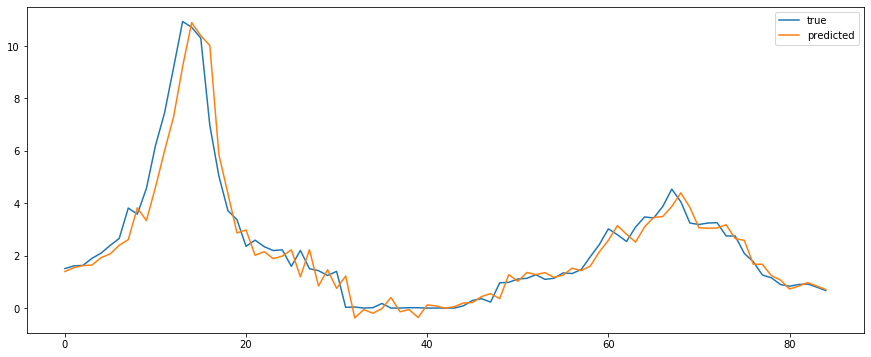

0.6363320574319546

In [15]:
# AR with retrain
AutoReg_Walk_Forward('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 1)
AutoReg_Walk_Forward('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 1)

## Autoregression with Google Trend(ARGO)

We also incorporate the Linear Autoregression model with Google Trend data. We use a linear combination of 26 autoregressive flu observations and Top 25% most relevant flu searches as predictors to predict future flu trend in a certain state. For the Google Trend model, we used Lasso to exclude any overly influential terms and prevent overfitting. 

In [16]:
def ARGO(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS','GT']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            if t % refit_period == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
        else:
            if t == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the ARGO Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

RMSE for the ARGO Model of Texas is 0.794215


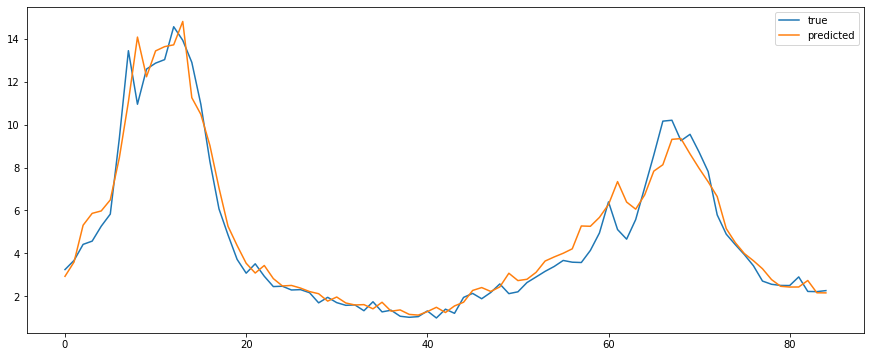

RMSE for the ARGO Model of New York is 0.938074


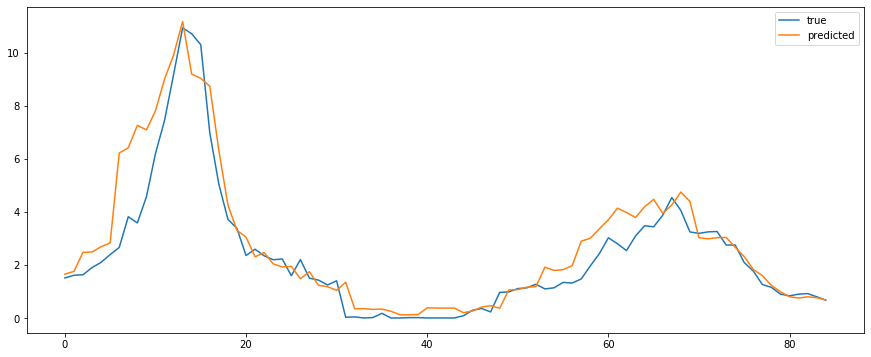

0.9380739935475504

In [17]:
# ARGO no refit
ARGO('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)
ARGO('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)

RMSE for the ARGO Model of Texas is 0.794447


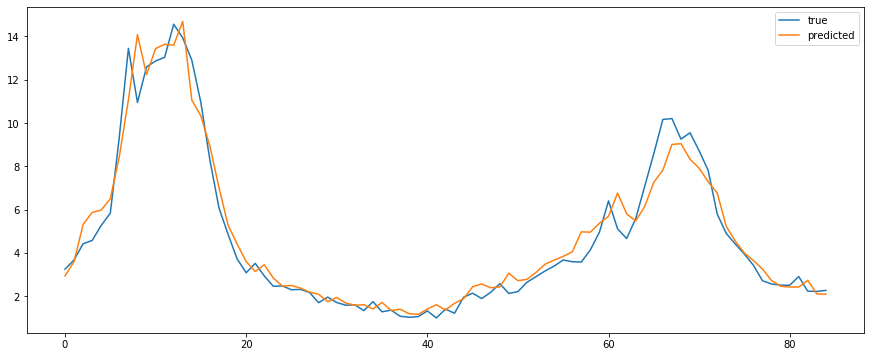

RMSE for the ARGO Model of New York is 0.927351


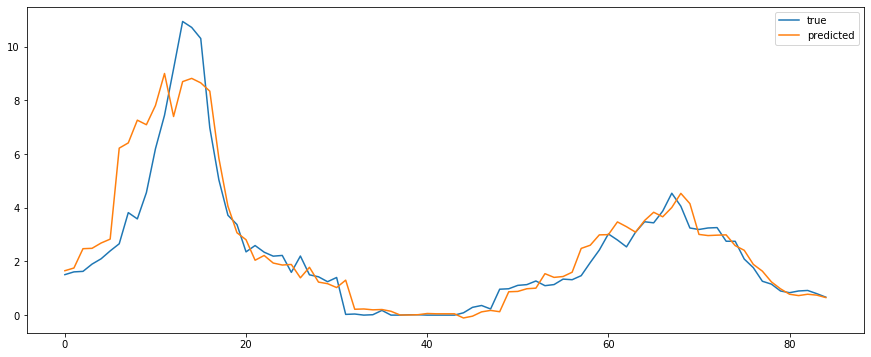

0.927351419681702

In [18]:
# ARGO with refit
ARGO('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)
ARGO('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)

## Network Autoregression

The Network Autoregression model is adapted from the previous Linear Autoregression model. But instead of using the data from one state, we use the flu observations from other states as well. The NAR model uses the linear combination of 26 autoregressive terms of target state and the flu data from all other states available to predict target state's future flu trend. We also incorporate a form that includes target state's Google Trend Data, and again use Lasso to regularize.

In [170]:
def NAR(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, with_gt = False, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    if with_gt: lag_cols += ['GT']
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS','other_states']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            if t % refit_period == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
        else:
            if t == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the NAR Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

In [171]:
# NAR with refit no GT
NAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 1, with_gt=False)
NAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 1, with_gt=False)

RMSE for the NAR Model of Texas is 0.979302
RMSE for the NAR Model of New York is 0.605934


0.6059339724831716

In [172]:
# NAR with refit, with GT
NAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 12, with_gt=True)
NAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 12, with_gt=True)

RMSE for the NAR Model of Texas is 0.828209
RMSE for the NAR Model of New York is 0.879833


0.8798328319635392

### Prepare data for NN models

In [91]:
# Helper functions-normalize the data
def minmax_transform(X_train, X_test, return_scaler=False):
    """ Uses MinMaxScaler to scale X_train and X_test
        to 0 and 1, scaled using X_train
    """
    col_name = X_train.columns
    scaler = MinMaxScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_train = scaler.transform(X_train)
    if return_scaler:
        return pd.DataFrame(X_train), pd.DataFrame(X_test), scaler
    else:
        return pd.DataFrame(X_train), pd.DataFrame(X_test)

In [54]:
# get train & test
def get_data(state, future_week, with_gt=False, predictor_state=None):
    '''
    state: state to predict
    future_week: the future week to forcast, chosen from [1,2,4,8]
    with_gt: whether to include GT data
    predictor_state: list of states as predictors
    '''
    assert future_week in [1,2,4,8]
    
    train, test = train_dfs[state], test_dfs[state]
    X_train, X_test = pd.DataFrame(), pd.DataFrame()
    
    # if not specified, only include the flu data as predictor
    flu_train, flu_test, scaler = minmax_transform(pd.DataFrame(train.iloc[:, 1]), pd.DataFrame(test.iloc[:, 1]),
                                                  return_scaler=True)
    X_train['flu_data'], X_test['flu_data'] = flu_train[0], flu_test[0]
    target = 'target_' + str(future_week)
    y_train, y_test = pd.DataFrame(scaler.transform(train[[target]])), test[[target]]
    
    if with_gt and predictor_state:
        for p in predictor_state:
            # flu
            state_train, state_test = train_dfs[p], test_dfs[p]
            flu_train, flu_test = minmax_transform(
                pd.DataFrame(state_train.iloc[:, 1]), pd.DataFrame(state_test.iloc[:, 1]))
            X_train[p], X_test[p] = flu_train, flu_test
            # google trend
            X_train_gt, X_test_gt = state_train.iloc[:, 2:-4], state_test.iloc[:, 2:-4] 
            gt_train, gt_test = minmax_transform(X_train_gt, X_test_gt)
            for i, col in enumerate(X_train_gt.columns):
                X_train[p+' '+col], X_test[p+' '+col] = gt_train[i], gt_test[i]
    
    elif with_gt: # include google trend data
        X_train_gt, X_test_gt = train.iloc[:, 2:-4], test.iloc[:, 2:-4] # google trend data
        gt_train, gt_test = minmax_transform(X_train_gt, X_test_gt)
        for i, col in enumerate(X_train_gt.columns):
            X_train[col], X_test[col] = gt_train[i], gt_test[i]
            
    elif predictor_state:
        for p in predictor_state:
            state_train, state_test = minmax_transform(
                pd.DataFrame(train_dfs[p].iloc[:, 1]), pd.DataFrame(test_dfs[p].iloc[:, 1]))
            X_train[p], X_test[p] = state_train, state_test
            
    X_all, y_all = pd.concat([X_train, X_test]), pd.concat([y_train, y_test])
    
    return X_train, X_test, X_all, y_train, y_test, y_all, scaler

## Vanilla NN model

The basic Neural Network model provides the option of using only autoregressive flu observations, autoregressive flu observation with data from other states and the option of adding google trend data as previous models to forcast future flu trend (1-week, 2-week, 4-week, 8-week). We also incorporate the Linear Autoregression model with Google Trend data. For the Google Trend model, we used Lasso to exclude any overly influential terms and prevent overfitting. 

In [11]:
def VanillaNN(state,predictor_state = None,if_plot=True,if_gt = True,lag = 1):
    # def Neural network
    def NN(X_train,y_train,batch_size,epochs,verbose):
        drop_rate = .01
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = batch_size
        epochs = epochs
        validation_split = 0.1
        verbose = verbose
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(input_dim=len(X_train.keys()),units = 128,activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
        model.add(tf.keras.layers.Dense(units = 64,activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
        model.add(tf.keras.layers.Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X_train, X_test, X, y_train, y_test, y_all,scaler = get_data(state, 
                                                      lag,
                                                      with_gt=if_gt,
                                                      predictor_state=predictor_state)
    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)
    
    # Training Model
    if predictor_state == None:
        predictor_state = ['flu_data']
    for i in range(26):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
     
    clf = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109)
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = NN(X_train,y_train,32,10,0)
    preds = nn.predict(X_test)
    reverse_preds = scaler.inverse_transform(preds)
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, reverse_preds)))
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(reverse_preds, label='predicted')
        plt.legend()
        plt.show() 
    return reverse_preds

In [12]:
def plot_prediction(TS,TSOS,TSGT,TSOSGT,state):
    _, _, _, _, y_test, y_all,scaler = get_data(state, 1,with_gt=False,predictor_state=None)
    y_test = y_test.values.reshape(-1,)
    fig,ax = plt.subplots(2,2,figsize = (15,10))
    ax[0][0].plot(y_test.tolist(), label='true')
    ax[0][0].plot(TS, label='predicted TS only')
    ax[0][0].set_title("RMSE is:%s"%np.sqrt(mean_squared_error(y_test, TS)))
    ax[0][1].plot(y_test.tolist(), label='true')
    ax[0][1].plot(TSOS, label='predicted TS and other state')
    ax[0][1].set_title("RMSE is %s"%np.sqrt(mean_squared_error(y_test, TSOS)))
    ax[1][0].plot(y_test.tolist(), label='true')
    ax[1][0].plot(TSGT, label='predicted TS and GT')
    ax[1][0].set_title("RMSE is %s"%np.sqrt(mean_squared_error(y_test, TSGT)))
    ax[1][1].plot(y_test.tolist(), label='true')
    ax[1][1].plot(TSOSGT, label='predicted TS,other state and GT')
    ax[1][1].set_title("RMSE is%s"%np.sqrt(mean_squared_error(y_test, TSOSGT)))
    ax[0][0].legend()
    ax[0][1].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    title = "Prediction for NN model for " + state
    fig.suptitle(title,size = 20)

In [30]:
# Texas
NN_TS1 = VanillaNN('Texas',None,False,False,1)
# Autocorrelation without GT
NN_TSOS1 = VanillaNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False, False,1)
# With goolge trend
NN_TSGT1 = VanillaNN('Texas',None,False,True,1)
# With goolge trend
NN_TSOSGT1 = VanillaNN('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)

Test RMSE:  1.0104841514600351
Test RMSE:  1.1199715794371208
Test RMSE:  1.5053348384460028
Test RMSE:  1.584203195582157


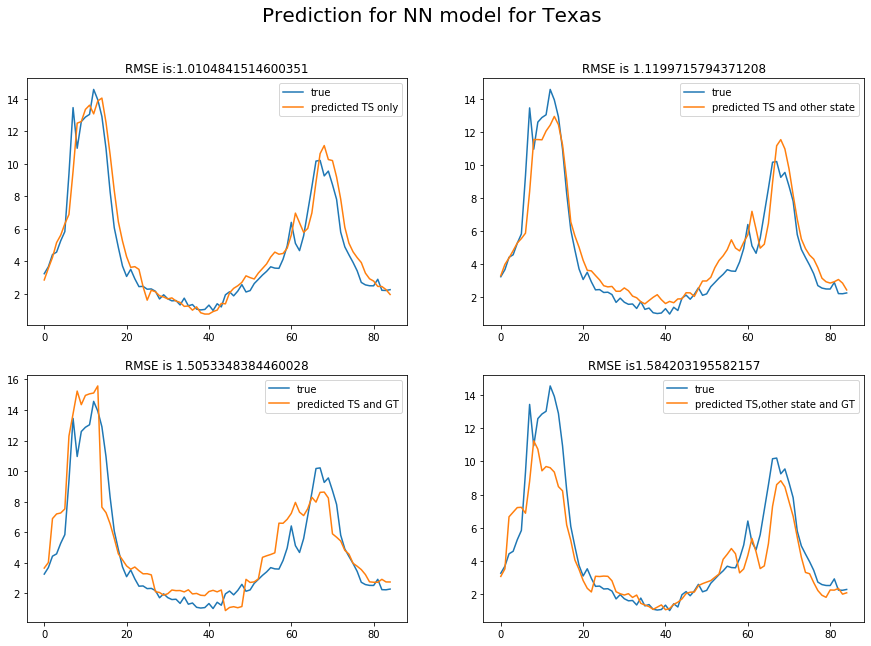

In [35]:
plot_prediction(NN_TS1,NN_TSOS1,NN_TSGT1,NN_TSOSGT1,'Texas')

In [13]:
# Newyork
NN_TS2 = VanillaNN('New York',None,False,False,1)
# Autocorrelation without GT
NN_TSOS2 = VanillaNN('New York',['Massachusetts', 'New Jersey', 'Vermont', 'Connecticut'],False, False,1)
# With goolge trend
NN_TSGT2 = VanillaNN('New York',None,False,True,1)
# With goolge trend
NN_TSOSGT2 = VanillaNN('New York',['Massachusetts', 'New Jersey', 'Vermont', 'Connecticut'],False,True,1)

Test RMSE:  0.7052718277411208
Test RMSE:  1.043038230711011
Test RMSE:  1.9719484339592928
Test RMSE:  1.6813358916506522


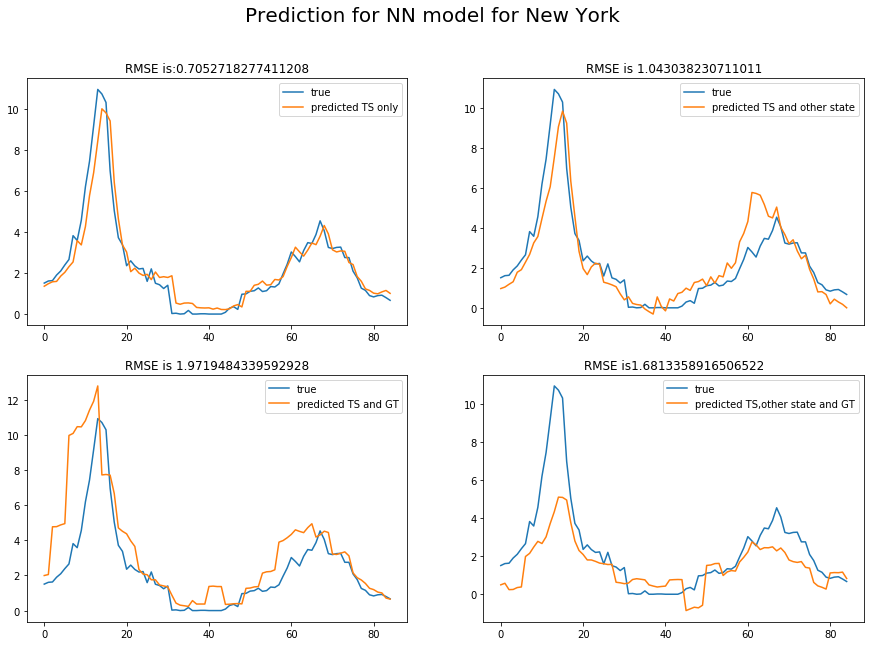

In [14]:
plot_prediction(NN_TS2,NN_TSOS2,NN_TSGT2,NN_TSOSGT2,'New York')

## GRU##

The traditional NN model may not capture the long term dependencies properly. Therefore, we decided to include a model that can capture this. After trying with LSTM and its variant GRU, we saw that they have similar performances, mostly because they share similar structures. The GRU model is more computationally efficient, so we decided to go with the GRU model. The GRU model is built based on a RNN structure with a GRU layer of 100 units, and it also provides the option of using only autoregressive flu observations, autoregressive flu observation with data from other states and the option of adding google trend data to help forcast future flu trend (1-week, 2-week, 4-week, 8-week). For the model that uses google trend data, we used Lasso to exclude any overly influential terms and prevent overfitting.

In [36]:
def GRU_model(state,predictor_state = None,if_plot=True,if_gt = True,lag = 1):
    # def Neural network
    def gru(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = batch_size
        epochs = epochs
        validation_split = 0.2
        verbose = verbose
        model = tf.keras.models.Sequential()
        model.add(GRU(100, input_shape = (1,X_train.shape[2]),
                            return_sequences= True))
        model.add(Dropout(0.2))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X_train, X_test, X, y_train, y_test, y_all,scaler = get_data(state, 
                                                      lag,
                                                      with_gt=if_gt,
                                                      predictor_state=predictor_state)
    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)
    # Training Model
    if predictor_state == None:
        predictor_state = ['flu_data']
    for i in range(26):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
     
    clf = LassoCV()
    sel_ = SelectFromModel(clf)
    sel_.fit(X_train, y_train)
    feature_idx = sel_.get_support()
    feature_name = X_train.columns[feature_idx]
    X_train, X_test = sel_.transform(X_train),sel_.transform(X_test)
    X_train = pd.DataFrame(X_train,columns = feature_name)
    X_test = pd.DataFrame(X_test,columns = feature_name)
    nn = gru(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
                 np.asarray(y_train),16,15,0)
    preds = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
    preds = [i[0] for i in preds]
    reverse_preds = scaler.inverse_transform(preds)
    
    #print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, reverse_preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(reverse_preds, label='predicted')
        plt.legend()
        plt.show()
    return reverse_preds

In [24]:
# Texas
GRU_TS1 = GRU_model('Texas',None,False,False,1)
# Autocorrelation with other states without GT
GRU_TSOS1 = GRU_model('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)
# With goolge trend
GRU_TSGT1 = GRU_model('Texas',None,False,True,1)
# With goolge trend and other states
GRU_TSOSGT1 = GRU_model('Texas',['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'],False,True,1)

Test RMSE:  1.0626244834738248
Test RMSE:  1.2965284286114154
Test RMSE:  1.1359960560213254
Test RMSE:  1.4810486990319454


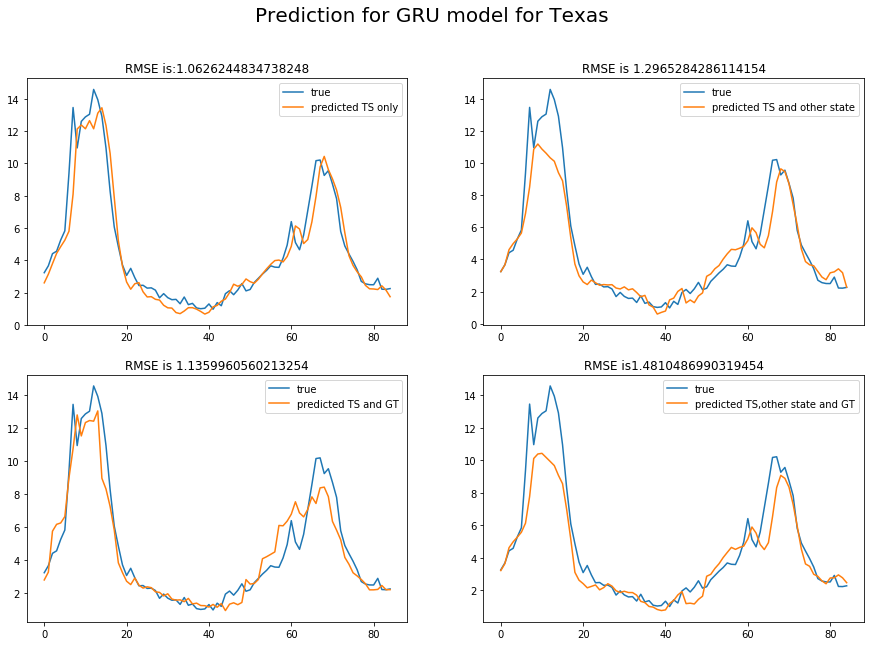

In [25]:
plot_prediction(GRU_TS1,GRU_TSOS1,GRU_TSGT1,GRU_TSOSGT1,'Texas')

In [26]:
# New York
GRU_TS2 = GRU_model('New York',None,False,False,1)
# Autocorrelation with other states without GT
GRU_TSOS2 = GRU_model('New York',['Massachusetts', 'New Jersey', 'Vermont', 'Connecticut'],False, False,1)
# With goolge trend
GRU_TSGT2 = GRU_model('New York',None,False,True,1)
# With goolge trend and other states
GRU_TSOSGT2 = GRU_model('New York',['Massachusetts', 'New Jersey', 'Vermont', 'Connecticut'],False,True,1)

Test RMSE:  0.7018959321106815
Test RMSE:  0.9770915216197947
Test RMSE:  0.9355814943915515
Test RMSE:  1.026985570313837


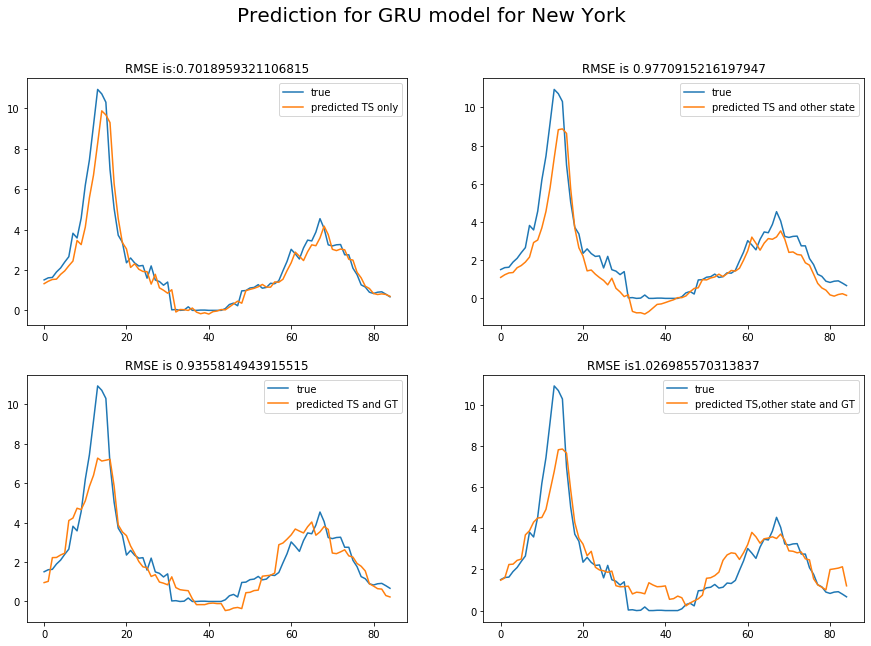

In [27]:
plot_prediction(GRU_TS2,GRU_TSOS2,GRU_TSGT2,GRU_TSOSGT2,'New York')

# Results

In [93]:
# get neighbor data
neighbors = pd.read_csv('../data/state_neighbors.csv').set_index('state')
neighbors['neigh_state'] = neighbors['neigh_state'].apply(literal_eval)
neighbors.head()

,neigh_state
state,
Alabama,"[Georgia, Mississippi, Tennessee]"
Alaska,[Washington]
Arizona,"[California, Colorado, New Mexico, Nevada, Utah]"
Arkansas,"[Louisiana, Missouri, Mississippi, Oklahoma, T..."
California,"[Hawaii, Nevada, Oregon]"


### Get the RMSEs and plot for each model

In [22]:
# get rmse for model
def get_rmse(model, with_gt=False):
    rmse = {}
    for week in [1,2,4,8]:
        rmse[week] = []
        for state in all_states:
            if model == persistence:
                rmse[week].append(model(state, target_lag=week, if_plot=False, verbose=0))
            elif model in [AutoReg_Walk_Forward, ARGO]:
                rmse[week].append(model(state, ar_lag=26, target_lag=week, if_plot=False, if_refit=True, refit_period=12, verbose=0))
            elif model == NAR:
                rmse[week].append(model(state, ar_lag=26, target_lag=week, if_plot=False, if_refit=True, refit_period=12, with_gt=with_gt, verbose=0))
            elif model == VanillaNN:
                if predictor state: 
                    predict = neighbors.loc[state, 'neigh_state']
                _,error = model(state,predict,False,with_gt,week)
                rmse[week].append(error)
            else:
                rmse[week].append(model(state, None, False,with_gt,week))
    return rmse

In [23]:
# compute each rmse
# persistence
persistence_rmse = get_rmse(persistence)

# Linear Autoregression
ar_rmse = get_rmse(AutoReg_Walk_Forward) # without google trend
argo_rmse = get_rmse(ARGO, with_gt=True) # with google trend

# Linear Network Autoregression
nar_rmse = get_rmse(NAR) # without google trend
nargo_rmse = get_rmse(NAR, with_gt=True) # with google trend

# Vanilla NN
nn_rmse = get_rmse(VanillaNN,False,False) # without other states and without google trend
nn_rmsegt = get_rmse(VanillaNN,True,False) # without other states and with google trend
nnos_rmse = get_rmse(VanillaNN,False,True) # with other states and without google trend
nnos_rmsegt = get_rmse(VanillaNN,True,True) # without other states and without google trend

# GRU
gru_rmse = get_rmse(GRU_model) # without google trend
gru_rmse_gt = get_rmse(GRU_model, with_gt=True) # with google trend

In [50]:
# put rmses in dataframes to prepare for plotting
rmse_df = {}
for future_week in [1,2,4,8]:
    # get the data
    # without GT
    persistence_df = pd.DataFrame(persistence_rmse[future_week])
    persistence_df['model'] = 'persistence'
    persistence_df['gt_no_gt'] = 'Without GT'

    autoregression_df = pd.DataFrame(ar_rmse[future_week])
    autoregression_df['model'] = 'AR'
    autoregression_df['gt_no_gt'] = 'Without GT'

    lnautoregression_df = pd.DataFrame(nar_rmse[future_week])
    lnautoregression_df['model'] = 'NAR'
    lnautoregression_df['gt_no_gt'] = 'Without GT'
    
    nn_df = pd.DataFrame(nn_rmse[future_week])
    nn_df['model'] = 'NN no other state'
    nn_df['gt_no_gt'] = 'Without GT'

    nnos_df = pd.DataFrame(nnos_rmse[future_week])
    nnos_df['model'] = 'NN with other state'
    nnos_df['gt_no_gt'] = 'Without GT'
    
    gru_df = pd.DataFrame(gru_rmse[future_week])
    gru_df['model'] = 'gru'
    gru_df['gt_no_gt'] = 'Without GT'
    
    # with GT
    persistence_gt = pd.DataFrame(persistence_rmse[future_week])
    persistence_gt['model'] = 'persistence'
    persistence_gt['gt_no_gt'] = 'With GT'

    autoregression_gt = pd.DataFrame(argo_rmse[future_week])
    autoregression_gt['model'] = 'AR'
    autoregression_gt['gt_no_gt'] = 'With GT'

    lnautoregression_gt = pd.DataFrame(nargo_rmse[future_week])
    lnautoregression_gt['model'] = 'NAR'
    lnautoregression_gt['gt_no_gt'] = 'With GT'
    
    nnrmse_gt = pd.DataFrame(nn_rmsegt[future_week])
    nnrmse_gt['model'] = 'NN no other state'
    nnrmse_gt['gt_no_gt'] = 'With GT'

    nnosrmse_gt = pd.DataFrame(nnos_rmsegt[future_week])
    nnosrmse_gt['model'] = 'NN with other state'
    nnosrmse_gt['gt_no_gt'] = 'With GT'
    
    gru_gt = pd.DataFrame(gru_rmse[future_week])
    gru_gt['model'] = 'gru'
    gru_gt['gt_no_gt'] = 'With GT'

    rmse_df[future_week] = pd.concat([persistence_df, autoregression_df, lnautoregression_df, nn_df, nnos_df, gru_df,
                                      persistence_gt, autoregression_gt, lnautoregression_gt, nnrmse_gt, nnosrmse_gt, gru_gt], ignore_index=True)

In [194]:
# with open('result.pkl', 'wb') as f:
#     pickle.dump(rmse_df, f, pickle.HIGHEST_PROTOCOL)

In [195]:
with open('result.pkl', 'rb') as f:
    rmse_df = pickle.load(f)

### Plot RMSE

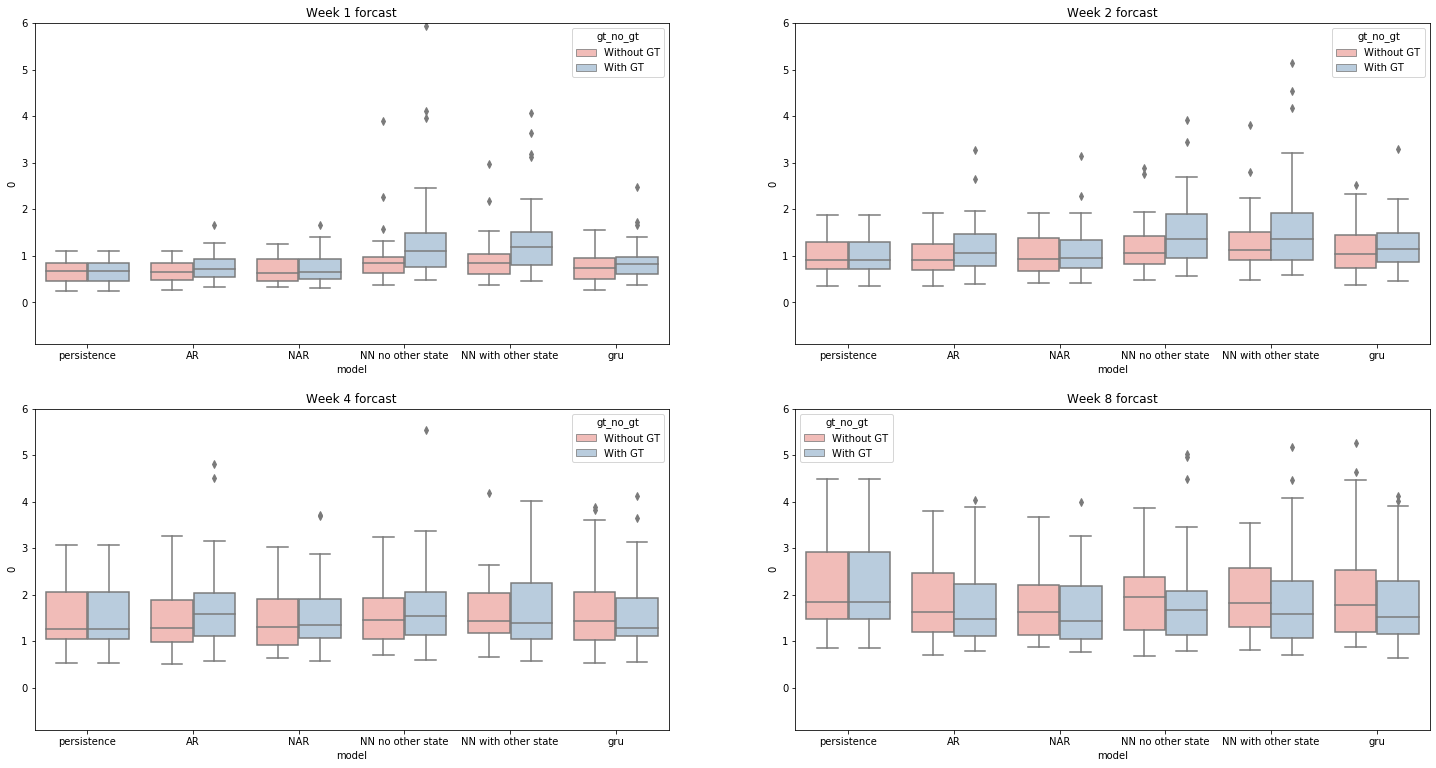

In [193]:
# plot
plt.figure(figsize = [25, 13])
for i, week in enumerate([1,2,4,8]):
    plt.subplot(2,2,i+1)
    sns.boxplot(x="model", y=0, hue="gt_no_gt", data=rmse_df[week], palette="Pastel1")
    plt.ylim([-.9, 6])
    plt.title('Week {} forcast'.format(week))

### Wilcoxon signed-rank test test

In [197]:
def wilcoxon_test(baseline, model_rmse, fmt=True):
    """ Perform wilcoxon_test with 
        Null: baseline RMSE <= model_rmse
        Alt:  baseline RMSE > model_rmse
    """
    stat, p_val = wilcoxon(baseline, model_rmse, alternative='greater')
    if fmt:
        return f"{stat:.4} ({p_val:.4})"
    return stat, p_val

wilcoxon_test_result = {c:[] for c in [1,2,4,8]}

for week, result_df in rmse_df.items():
    
    baseline = result_df[(result_df.model == 'persistence') & (result_df.gt_no_gt == 'Without GT')][0].values

    stat_p_list = []
    for model in result_df.model.unique()[1:]:
        nogt_rmse = result_df[(result_df['model'] == model) & (result_df.gt_no_gt == 'With GT')][0].values
        gt_rmse = result_df[(result_df['model'] == model) & (result_df.gt_no_gt == 'Without GT')][0].values
        stat_p_list.append(wilcoxon_test(baseline, nogt_rmse))
        stat_p_list.append(wilcoxon_test(baseline, gt_rmse))
    wilcoxon_test_result[week] = stat_p_list

models = ['AR', 'ARGO', 'NAR', 'NAR with GT', 'Vanilla NN', 'Vanilla NN with GT', 'NN with other states', 'NN with other states and GT', 'GRU', 'GRU with GT']

pd.DataFrame(wilcoxon_test_result, index=models)

,1,2,4,8
AR,157.0 (1.0),240.0 (0.9999),474.0 (0.9428),1.219e+03 (9.921e-09)
ARGO,686.0 (0.3198),949.0 (0.001319),1.064e+03 (1.918e-05),1.213e+03 (1.384e-08)
NAR,540.0 (0.8267),583.0 (0.7006),730.0 (0.1859),1.224e+03 (7.496e-09)
NAR with GT,677.0 (0.3515),809.0 (0.04891),961.0 (0.0008956),1.227e+03 (6.329e-09)
Vanilla NN,1.0 (1.0),36.0 (1.0),575.0 (0.7269),1.028e+03 (8.175e-05)
Vanilla NN with GT,132.0 (1.0),320.0 (0.9989),729.0 (0.1885),1.148e+03 (4.154e-07)
NN with other states,0.0 (1.0),52.0 (1.0),605.0 (0.6231),1.062e+03 (2.085e-05)
NN with other states and GT,88.0 (1.0),168.0 (1.0),665.0 (0.3953),1.164e+03 (1.863e-07)
GRU,46.0 (1.0),193.0 (1.0),729.0 (0.1885),1.163e+03 (1.96e-07)
GRU with GT,110.0 (1.0),396.0 (0.9901),667.0 (0.3879),1.034e+03 (6.472e-05)


Based on the above analysis, we see that the Autoregression model with Google Trend(ARGO), and the Network Autoregression with Google Trend(NARGT) achieved the best performance among all. When the prediction horizon is small, no model is significantly better than the baseline persistence model. But as the horizon increases, the improvement is more and more significant. At horizon 8, all models did a substantially better job than the baseline.

# Conclusion

To reach the goal of forcasting future flu trend for 50 states, we used the first 368 weeks as our traning data, and test on the remaining 93 states. We tried the following models: Persistence(baseline), Autoregression(AR), Network Autoregression that involves other state(NAR), Vanilla Neural Network(NN), and Gated Recurrent Unit Networks(GRU), each was also incorporated with Google Trend data except for Persistence. For the autoregressive models, we retrain at each 3-month(12-week) period, and all models took 26 autoregressive terms to cover a 6-month trend. At the end, the simple AR model with Google Trend and NAR model with Google Trend were the best models.

There are some limitations for our project and room for improvement. For example, we realized a 80-20 train-test split might not be the best choice, as some of the peaks in later flu data are a lot higher than the previous ones due to its spread in 2019. If possible, we could also incorporate some other data into our models to improve performance, such as Twitter data, hospital data, etc. 